In [18]:
from dotenv import load_dotenv
import os
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain 
from langchain_core.prompts import ChatPromptTemplate
from langchain_chroma import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_groq import ChatGroq

# Load environment variables
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY") 
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_ENDPOINT = os.getenv("LANGCHAIN_ENDPOINT")
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"



In [19]:
# Initialize embeddings and model
embeddings = OllamaEmbeddings(model="mistral", base_url="http://host.docker.internal:11434")
model = ChatGroq(temperature=1, model_name="llama3-70b-8192", api_key=groq_api_key)

In [20]:
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph


def create_agent(model, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | model.bind_tools(tools)

In [21]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [22]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [23]:
import functools
from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


# Research agent and node
research_agent = create_agent(
    model,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    model,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [24]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [25]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [26]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

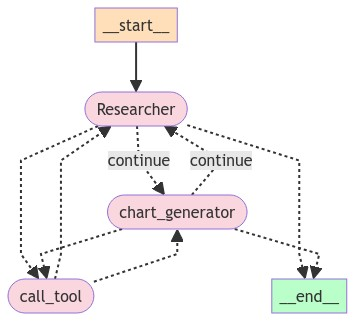

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [28]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=   "Identify stocks that are currently breaking out and suitable for short-term investment  as of May 10, 2024, 21:50:18 UTC. After selection, code a script to retrieve their recent performance data and plot a line graph showing this data"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_531j', 'function': {'arguments': '{"query":"stocks breaking out suitable short-term investment"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_time': 0.231, 'completion_tokens': 70, 'prompt_time': 0.627, 'prompt_tokens': 1080, 'queue_time': None, 'total_time': 0.858, 'total_tokens': 1150}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_753a4aecf6', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-bab4e4ac-d075-496c-9147-b4514533b942-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'stocks breaking out suitable short-term investment'}, 'id': 'call_531j'}])], 'sender': 'Researcher'}}
----


{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://finance.yahoo.com/news/15-best-short-term-stocks-143112369.html", "content": "S&P 500\\nDow 30\\nNasdaq\\nRussell 2000\\nCrude Oil\\nGold\\nSilver\\nEUR/USD\\n10-Yr Bond\\nGBP/USD\\nUSD/JPY\\nBitcoin USD\\nCMC Crypto 200\\nFTSE 100\\nNikkei 225\\n15 Best Short-Term Stocks To Buy Now\\n While acknowledging the step back and near-term headwinds, we believe BREIT has plenty of runway to meet redemptions without being forced to liquidate assets\\nWe recently reduced the size of the Fund\\u2019s investment in Blackstone Inc. because of our expectation of a slowdown in its growth outlook. Here\'s what the firm said:\\n\\u201cWe continued to build our position in Cloudflare, Inc. (NYSE:NET) during the quarter as the shares declined with the overall software space and the long-term risk/ reward balance became more compelling. Here\'s what the firm said:\\n\\u201cBlackstone Inc. (NYSE:BX) was a detractor in the fourth quarter as